In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
np.random.seed(42)

import tensorflow as tf
tf.random.set_seed(42)

import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout

#from utils import confusion_matrix



In [ ]:
csv_filename = '/content/drive/MyDrive/motionProject/2023-02-22_6axis_data.csv'
df = pd.read_csv(csv_filename, encoding='utf8', low_memory=False) # utf8, cp949 |
df.shape


(3642, 8)

In [ ]:
display(df.head())

display(df.tail())

,dataId,label,accX,accY,accZ,gyroX,gyroY,gyroZ
0,1,idle,-8.9204,-1.0481,4.2497,-5.4917,-8.9241,-6.8647
1,1,idle,-8.9396,-1.0576,4.2592,-6.1782,-10.2970,-5.4917
2,1,idle,-8.9587,-1.0672,4.2353,-4.8053,-8.9241,-6.8647
3,1,idle,-8.9539,-1.0337,4.2353,-4.8053,-6.8647,-10.2970
4,1,idle,-8.9157,-1.0720,4.2497,-8.2376,-8.2376,-15.1022


,dataId,label,accX,accY,accZ,gyroX,gyroY,gyroZ
3637,67,sit,-9.2602,-0.0335,3.5701,108.4616,-59.0360,-38.4421
3638,67,sit,-9.2507,-0.0287,3.5749,114.6397,-54.9172,-53.5443
3639,67,sit,-9.2315,-0.0096,3.5174,113.2668,-51.4849,-52.1714
3640,67,sit,-9.2650,0.0479,3.4839,105.0292,-50.7984,-55.6037
3641,67,sit,-9.2698,0.0144,3.4792,96.1052,-47.3661,-63.8413


In [ ]:
train = df[['accX','accY','accZ','gyroX','gyroY','gyroZ']]

In [ ]:
test = df['label']

In [ ]:
test.unique()

array(['idle', 'sit', 'standup'], dtype=object)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train, test, test_size=0.33, random_state=42)
# train-test data split
# X는 input, Y는 (정답)output

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2440, 6), (1202, 6), (2440,), (1202,))

In [ ]:
epochs = 30
batch_size = 16
n_hidden = 32

In [ ]:
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [ ]:
# To reshape the data, convert the DataFrames to NumPy arrays first and then perform the reshape operation.

X_train = X_train.values
X_test = X_test.values

In [ ]:
X_train

array([[-9.288900e+00,  1.440000e-02,  3.483900e+00, -1.304280e+01,
         2.333980e+01, -8.924100e+00],
       [-9.064000e+00,  4.790000e-02,  3.488700e+00,  8.168940e+01,
        -1.180721e+02,  6.864700e+00],
       [-7.393800e+00,  5.260000e-02,  9.093000e-01, -2.162366e+02,
         4.791529e+02,  1.853460e+01],
       ...,
       [-9.667000e+00,  9.045000e-01,  2.215800e+00, -4.050150e+01,
        -9.541870e+01,  3.775560e+01],
       [-9.169300e+00,  1.387800e+00,  3.153700e+00, -3.432300e+00,
        -1.640652e+02, -3.981500e+01],
       [-6.628100e+00,  2.680000e-01,  2.493300e+00, -1.304285e+02,
         3.761831e+02,  8.649470e+01]])

In [ ]:
y_train = y_train.values
y_test = y_test.values

In [ ]:
# reshape input to be 3D [samples, timesteps, features]
# https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [ ]:
X_train.shape

(2440, 1, 6)

In [ ]:
X_test.shape

(1202, 1, 6)

In [ ]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2440, 1, 6) (2440,) (1202, 1, 6) (1202,)


In [ ]:
# 분류하고 싶은 클래스 개수
n_classes = _count_classes(y_train) 
n_classes

3

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
# ['PC' 'TABLET' 'MOBILE'] ==> [1 2 0]

In [ ]:
from keras.utils import to_categorical

# 원 핫 인코딩 
#    0 1 2
# 1  0 1 0
# 2  0 0 1
# 0  1 0 0

y_train = to_categorical(y_train, num_classes=n_classes)
y_test = to_categorical(y_test, num_classes=n_classes)

In [82]:
model = Sequential()

# n_hidden : 은닉계층에 임베딩되는 차원
# LSTM cell =  n_hidden 차원으로 만드는 것
# timestep : split해서 넣을 데이터 절편 크기
# X_train = (1762, 1, 6)
model.add(LSTM(n_hidden, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
# input차원 - (timesteps, input_dim)
model.add(Dropout(0.5))
model.add(LSTM(n_hidden))
model.add(Dropout(0.5))


model.add(Dense(n_classes, activation='softmax'))

# loss : predicted 결과와 real 결과의 차이
# optimizer : local optimum에 빠지지 않도록 넘어가게 해주는 장치, Adam 많이 씀
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))


Epoch 1/30
153/153 [==============================] - 5s 10ms/step - loss: 0.9945 - accuracy: 0.5328 - val_loss: 0.8486 - val_accuracy: 0.5774
Epoch 2/30
153/153 [==============================] - 1s 5ms/step - loss: 0.7561 - accuracy: 0.6602 - val_loss: 0.6362 - val_accuracy: 0.7363
Epoch 3/30
153/153 [==============================] - 1s 4ms/step - loss: 0.6232 - accuracy: 0.7246 - val_loss: 0.5678 - val_accuracy: 0.7554
Epoch 4/30
153/153 [==============================] - 1s 4ms/step - loss: 0.5926 - accuracy: 0.7434 - val_loss: 0.5445 - val_accuracy: 0.7521
Epoch 5/30
153/153 [==============================] - 1s 6ms/step - loss: 0.5763 - accuracy: 0.7697 - val_loss: 0.5224 - val_accuracy: 0.7770
Epoch 6/30
153/153 [==============================] - 2s 11ms/step - loss: 0.5516 - accuracy: 0.7598 - val_loss: 0.5115 - val_accuracy: 0.7770
Epoch 7/30
153/153 [==============================] - 1s 8ms/step - loss: 0.5399 - accuracy: 0.7775 - val_loss: 0.5108 - val_accuracy: 0.7729
Epoc

In [84]:
from keras.models import load_model

model.save('/content/drive/MyDrive/motionProject/lstm_model.h5')
model.summary()

#from google.colab import files
#files.download('saved_model')

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 1, 32)             4992      
                                                                 
 dropout_4 (Dropout)         (None, 1, 32)             0         
                                                                 
 lstm_7 (LSTM)               (None, 32)                8320      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 99        
                                                                 
Total params: 13,411
Trainable params: 13,411
Non-trainable params: 0
_________________________________________________________________


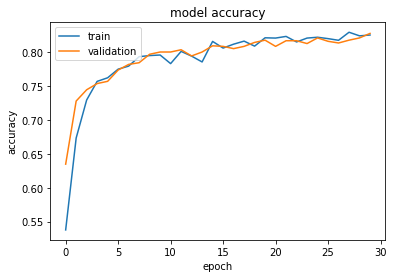

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

y_test_classes = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(model.predict(X_test), axis=1)
print(confusion_matrix(y_test_classes, y_pred_classes))

38/38 [==============================] - 0s 1ms/step
[[544   6  18]
 [ 13 173  98]
 [ 21  51 278]]


### 랜덤 인풋에 따른 예측결과

In [ ]:
model_new = tf.keras.models.load_model("/content/drive/MyDrive/motionProject/lstm_model.h5")

In [ ]:
test_data1 = np.array([[-100 , -10 , 6 , -224 , -224 , -112], [-101 , -9 , 4 , -56 , -203 , -161], [-100 , -9 , 8 , 7 , -196 , -112]])

In [ ]:
test_data1.shape

(3, 6)

In [ ]:
test_data1 = np.reshape(test_data1, (len(test_data1), 1, 6))

In [ ]:
test_data1.shape

(3, 1, 6)

In [ ]:
label = test.unique()
label

array(['idle', 'sit', 'standup'], dtype=object)

In [ ]:
np_class = np.argmax(model_new.predict(test_data1), axis=1)
np_class

1/1 [==============================] - 0s 356ms/step


array([2, 0, 0])

In [ ]:
label[np_class[0]]

'standup'

In [ ]:
test_data2 = np.array([-100 , -10 , 6 , -224 , -224 , -112])
test_data2 = np.reshape(test_data2, (1, 1, len(test_data2)))
label = test.unique()
np_class = np.argmax(model.predict(test_data2), axis=1)
label[np_class[0]]

1/1 [==============================] - 0s 19ms/step


'standup'